# Analysis and Visualisation

In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from classes import *

In [2]:
df = pd.read_csv(Path('processed_loan_payments.csv'))

to_date_list = ['issue_date',
                'earliest_credit_line', 
                'last_payment_date', 
                 
                'last_credit_pull_date']
to_numeric_list = []
to_categorical_list = ['term',
                       'grade', 
                       'sub_grade', 
                       'home_ownership', 
                       'verification_status', 
                       'loan_status', 
                       'purpose', 
                       'policy_code', 
                       'application_type',
                       'id',
                       'member_id']

df = DataTransform(df).to_date(to_date_list)
df = DataTransform(df).to_numeric(to_numeric_list)
df = DataTransform(df).to_categorical(to_categorical_list)


## Current State of Loans
To examine the current state of loans, we must calculate the percentage of the loans that are recovered against the investor funding and the total amount funded. These categorical results can be shown on a bar graph.

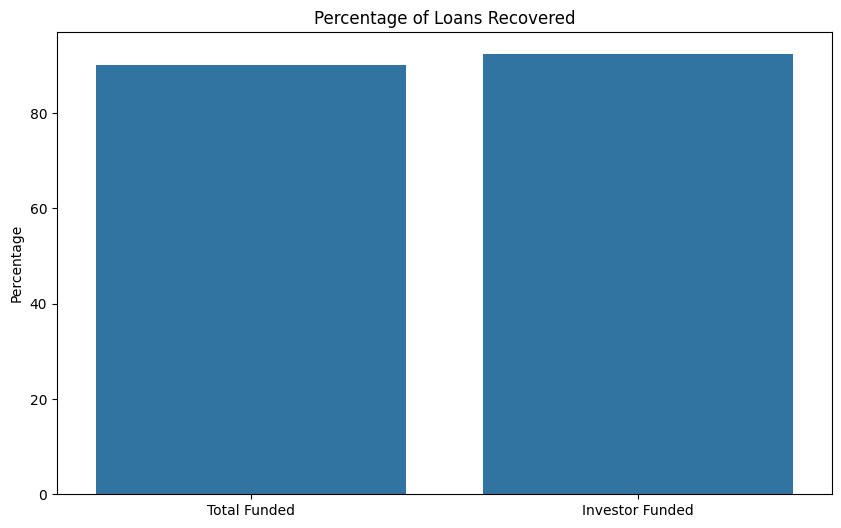

<Figure size 1000x600 with 0 Axes>

Percentage of loans recovered vs total funding: 90.16%
Percentage of loans recovered vs investor funding: 92.32%


In [3]:
total_payments_percentage = DataFrameInfo(df).column_percentage('total_payment', 'funded_amount')
total_payments_percentage_inv = DataFrameInfo(df).column_percentage('total_payment', 'funded_amount_inv')

Plotter(df).bar_plot(x=['Total Funded', 'Investor Funded'], y=[total_payments_percentage, total_payments_percentage_inv],ylab='Percentage',title='Percentage of Loans Recovered',size=(10,6))

print(f'Percentage of loans recovered vs total funding: {round(total_payments_percentage,2)}%')
print(f'Percentage of loans recovered vs investor funding: {round(total_payments_percentage_inv,2)}%')

The percentage of funding recovered has a negligible difference between the total funding and investor funding. We can also visualise what percentage of the total amount would be recovered up to 6 months in the future.

In [4]:
print('Percent of loans recovered per month:')
collection_pcent_dict = {}
for i in range(1,7): 
    collections_df = DataFrameInfo(df).total_recovered_over_period(i)
    collection_pcent = DataFrameInfo(collections_df).column_percentage('collections_over_period','loan_amount')
    collection_pcent_dict[i] = collection_pcent
    print(f'Month {i}: {round(collection_pcent,ndigits=2)}%')

Percent of loans recovered per month:
Month 1: 2.98%
Month 2: 5.94%
Month 3: 8.88%
Month 4: 11.81%
Month 5: 14.71%
Month 6: 17.59%


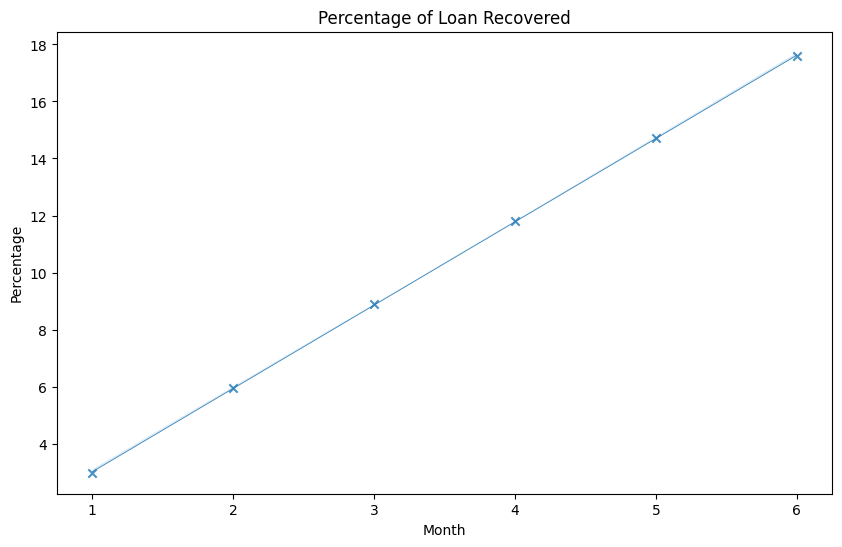

In [5]:
x= list(collection_pcent_dict.keys())
y=list(collection_pcent_dict.values())
Plotter(df).scatter_plot(x,y,xlab='Month',ylab='Percentage',title='Percentage of Loan Recovered',size=(10,6))

As expected, the total amount of loans recovered over the next 6 months follows a linear trend. This relationship will most likely look different for longer forecasts as a large proportion of loans are fulfilled. This model also assumes all scheduled instalments are paid, a factor that may impact the reliability of this prediction as we extrapolate further.

## Calculating Loss
We can calculate the percentage of loans that have been a loss to the company by identifing entries where the loan status is 'Charged Off'.

In [6]:
num_charged_off = len(df[df['loan_status'] == 'Charged Off'])
perc_charged_off = num_charged_off/len(df) * 100
print(f'{round(perc_charged_off,2)}% of loans historically have been charged off')

10.23% of loans historically have been charged off


Approximately 10% of all issued loans are charged off. We can also calculate the total amount that was paid towards these loans before being charged off:

In [7]:
df_charged_off = df[df['loan_status']=='Charged Off']
total_charged_off = df_charged_off['total_payment'].sum()

total_charged_off_perc = DataFrameInfo(df_charged_off).column_percentage('total_payment','loan_amount')

print(f'The total amount that was paid towards these loans before being charged off is {format(round(total_charged_off,2),",")}.')
print(f'This is {round(total_charged_off_perc,2)}% of the total amount loaned.')

The total amount that was paid towards these loans before being charged off is 34,506,317.54.
This is 49.05% of the total amount loaned.


## Projected Loss

We can calculate the loss in revenue these loans would have generated for the company if they had finished their term and visualise the loss projected over the remaining term of these loans.

In [8]:
monthly_revenue_lost = DataFrameInfo(df_charged_off).monthly_revenue_lost()
monthly_revenue_lost = [revenue_lost/1000000 for revenue_lost in monthly_revenue_lost]

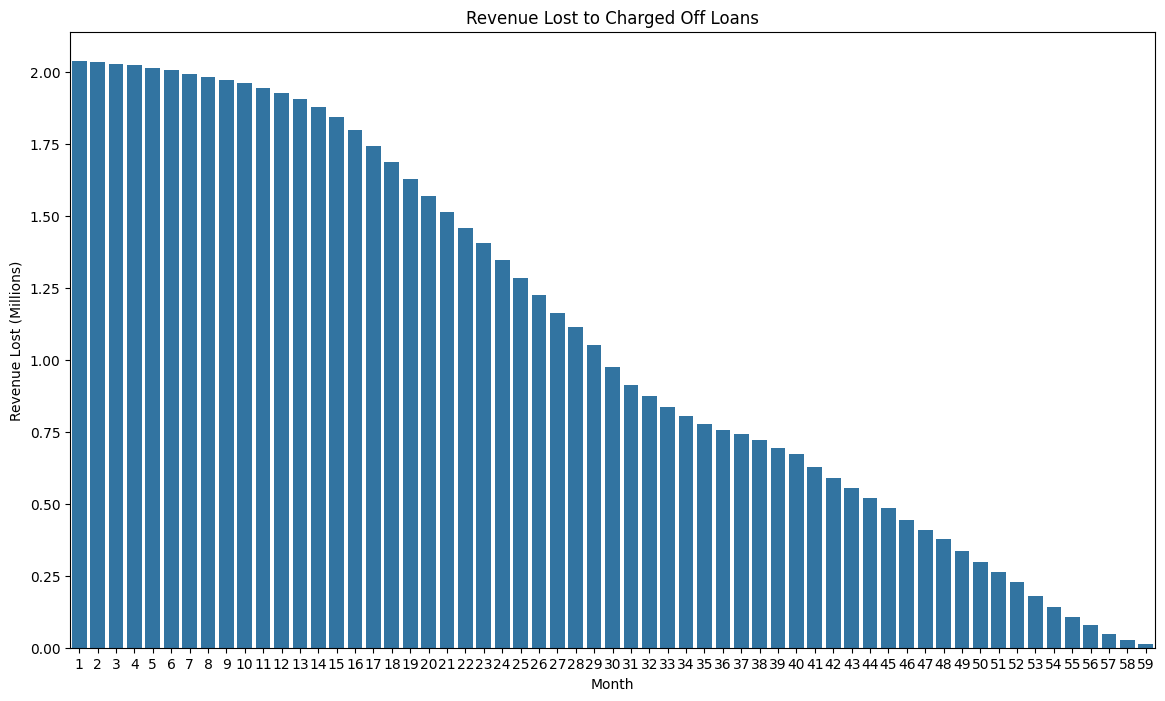

<Figure size 1400x800 with 0 Axes>

In [9]:
months = list(range(1, len(monthly_revenue_lost)+1))
Plotter(df_charged_off).bar_plot(x=months, y=monthly_revenue_lost, xlab='Month', ylab='Revenue Lost (Millions)', title='Revenue Lost to Charged Off Loans',size=(14,8))

total_lost_charged_off = sum(monthly_revenue_lost)


The total revenue lost to charged off loans is approximately 64 million. A similar graph can be created to illustrate the cumulative revenue lost, which will highlight the plateau in revenue lost as the loans come to term.

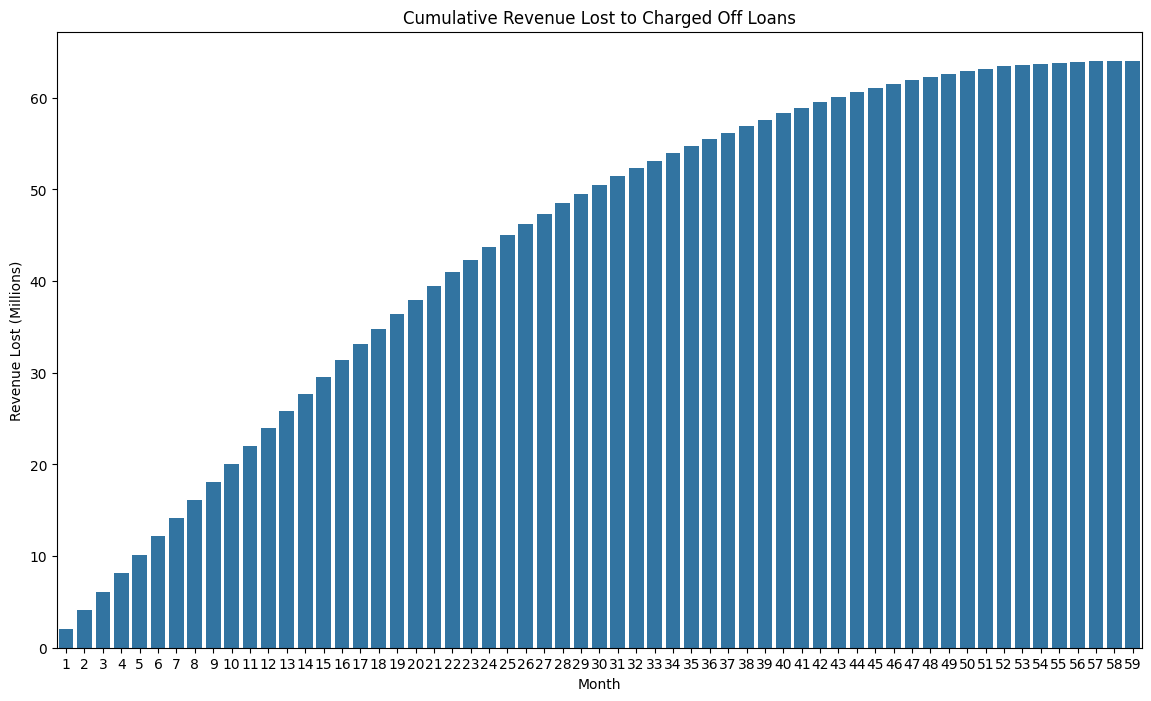

<Figure size 1400x800 with 0 Axes>

In [10]:
cumulative_monthly_revenue_lost = np.cumsum(monthly_revenue_lost)
Plotter(df_charged_off).bar_plot(x=months, y=cumulative_monthly_revenue_lost, xlab='Month', ylab='Revenue Lost (Millions)', title='Cumulative Revenue Lost to Charged Off Loans',size=(14,8))

## Possible Loss

There are customers who are currently behind with their loan payments.

The list of possible loan statuses is as follows:
- 'Current'
- 'Fully Paid'
- 'Charged Off'
- 'Late (31-120 days)'
- 'In Grace Period'
- 'Late (16-30 days)'
- 'Default'
- 'Does not meet the credit policy. Status:Fully Paid'
- 'Does not meet the credit policy. Status:Charged Off'

The subset of customers with loan statuses of 'Late (31-120 days)', 'In Grace Period' and 'Late (16-30 days)' are the ones who represent a risk to company revenue.

In [11]:
late_status = ['Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)']
late_df = df[df['loan_status'].isin(late_status)]
current_df = df[df['loan_status'].isin(['Current','Late (31-120 days)','In Grace Period', 'Late (16-30 days)'])]

In [12]:
late_perc = len(late_df)/len(df) *100
print(f'There are {len(late_df)} loans that are currently behind on payments.\nThese constitute {round(late_perc,2)}% of all the loans in the dataset.')

There are 898 loans that are currently behind on payments.
These constitute 1.76% of all the loans in the dataset.


In [13]:
late_monthly_revenue_lost = DataFrameInfo(late_df).monthly_revenue_lost()
late_total_revenue_lost = sum(late_monthly_revenue_lost)
current_total_expected_revenue = current_df['total_payment'].sum()
expected_perc_lost = late_total_revenue_lost/current_total_expected_revenue *100

print(f"If late loans were charged off, the projected loss would be {format(round(late_total_revenue_lost,2),',')}.")
print(f'This is {round(expected_perc_lost,2)}% of the expected income.')

If late loans were charged off, the projected loss would be 8,784,667.59.
This is 4.31% of the expected income.


In [14]:
late_default_status = ['Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)','Default']
late_default_df = df[df['loan_status'].isin(late_status)]
late_default_projected_revenue_lost = DataFrameInfo(late_default_df).monthly_revenue_lost()
late_default_total_revenue_lost = sum(late_default_projected_revenue_lost)

default_df = df[df['loan_status']=='Default']
default_projected_revenue_lost = DataFrameInfo(default_df).monthly_revenue_lost()
default_total_revenue_lost = sum(default_projected_revenue_lost)

total_expected_revenue = df['loan_amount'].sum()
default_lost_perc = default_total_revenue_lost/total_expected_revenue * 100
late_default_lost_perc = late_default_total_revenue_lost/total_expected_revenue * 100

print(f'{round(late_default_lost_perc,2)}% of the total expected revenue is lost to late and defaulted loans but only {round(default_lost_perc,2)}% are the defaulted loans.')

1.34% of the total expected revenue is lost to late and defaulted loans but only 0.08% are the defaulted loans.


## Indicators of Loss

We can identify what factors contribute to the probability of a loan leading to a loss of revenue by comparing these factors between successful and unsuccessful loans.

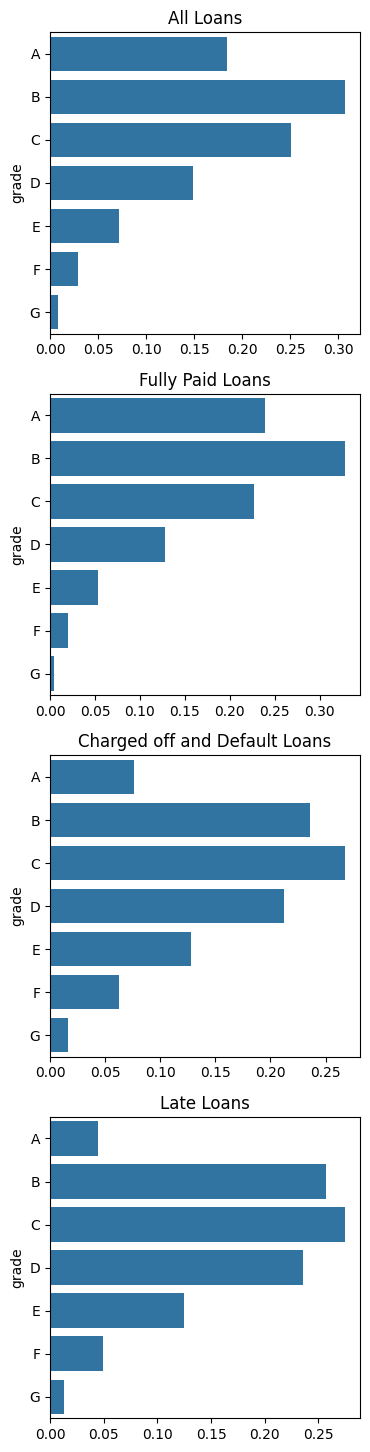

In [15]:
Plotter(df).risk_comparison('grade',size=(4,18))

From the bar plot above, it can be noted that on average, B grade loans are the most common loan provided to customers. Comparing the graphs for fully paid loans to charged off, default and late loans, shows that A and B grade loans are relatively safe and likely to be recovered, but C and below are much more likely to lead to a loss of revenue for the company.

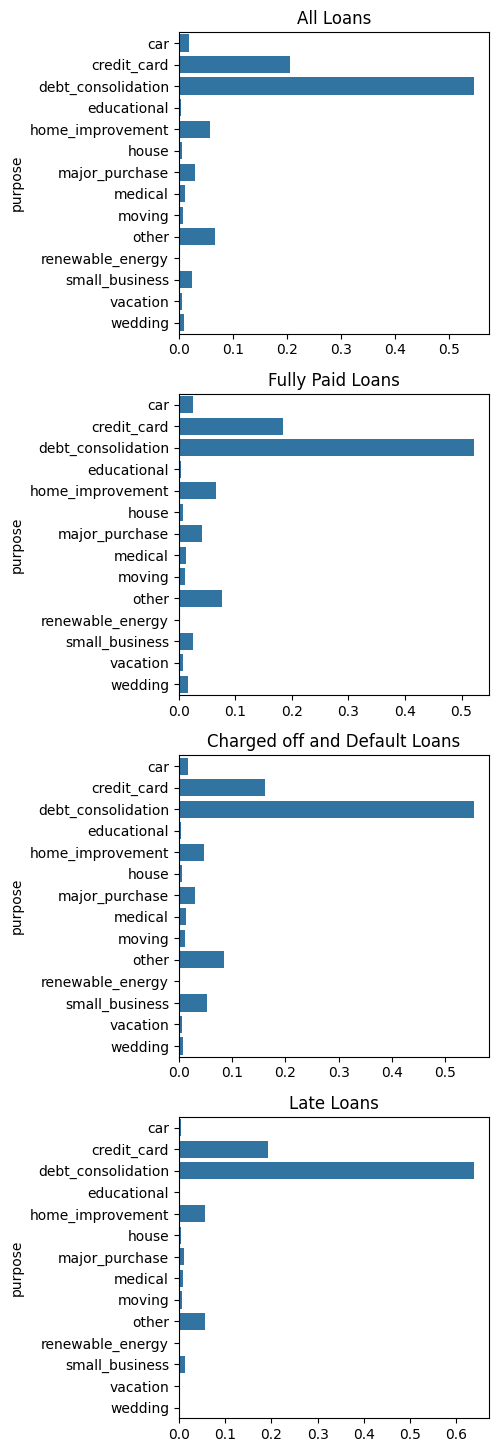

In [16]:
Plotter(df).risk_comparison('purpose',size=(4,18))

Comparing the bar charts for the purpose of the loan, it is clear that that most common reason to take out a loan is to consolidate debt. While this is an overwhelming majority which dwarfs the other possible reasons, there is a noticeable difference in the signature for late loans. It is evident that loans for debt consolidation or credit cards are more likely to suffer from delayed payments, making it a possible indicator for loss and a factor to consider in the future distribution of loans.

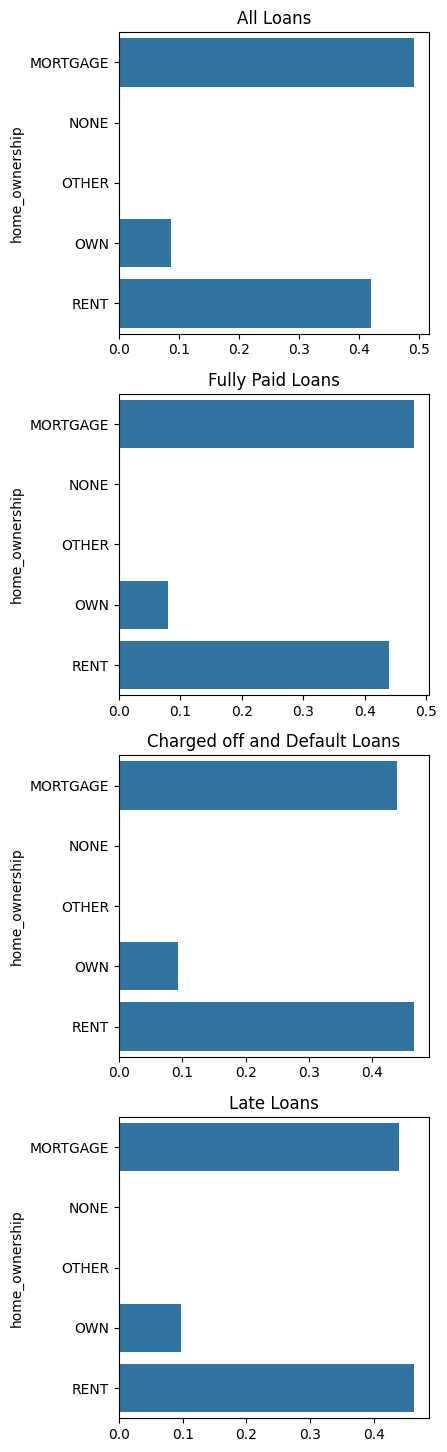

In [17]:
Plotter(df).risk_comparison('home_ownership',size=(4,18))

The proportion of customers who pay a mortgage is fairly constant throughout the subsets, however there is a clear rise in renters for late payments and charged off loans. It is evident from this plot that customers with a mortgage are more likely to reliably make payments and customers who rent are at a higher risk of making payments late, being charged off or defaulted. This suggests that the living situation of the customer may be a good indicator of loss and should be considered when providing a loan.